In [1]:
from collections import Counter
import tensorflow as tf
from tensorflow.keras import layers, models
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [38]:
def extract_sprite_rgb_values(image_path):
    """
    Extracts the dominant RGB values from the sprite (character) in the given image.

    Parameters:
    - image_path: The path to the input sprite image.

    Returns:
    - dominant_colors: A list of dominant RGB values (without counts).
    """
    image = Image.open(image_path).convert('RGB').resize((128, 128))
    np_image = np.array(image)
    
    # Mask out background (pure white in this example), modify this condition as needed for your background
    mask = np.any(np_image != [255, 255, 255], axis=-1)  # Exclude empty pixels
    sprite_pixels = np_image[mask]
    
    # Find the dominant colors and return them (ignore the counts)
    dominant_colors = [color for color, count in Counter(map(tuple, sprite_pixels)).most_common()]
    
    return dominant_colors

In [3]:
def build_model(input_shape, output_frames):
    """
    Builds a CNN-based encoder-decoder model for animation frame prediction.
    
    Parameters:
    input_shape (tuple): The shape of the input frame (height, width, channels).
    output_frames (int): The number of frames to generate as output.
    
    Returns:
    model: The compiled Keras model.
    """
    # Encoder
    encoder_input = layers.Input(shape=input_shape, name='encoder_input')
    
    # CNN layers to encode the first frame
    x = layers.Conv2D(64, (3, 3), padding='same', activation='relu')(encoder_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(256, (3, 3), padding='same', activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)

    # Latent representation
    latent = layers.Dense(512, activation='relu', name='latent_vector')(x)

    # Decoder (generate multiple frames)
    decoder_output = layers.Dense(output_frames * input_shape[0] * input_shape[1] * input_shape[2], activation='sigmoid')(latent)
    decoder_output = layers.Reshape((output_frames, input_shape[0], input_shape[1], input_shape[2]), name='decoder_output')(decoder_output)

    # Build and compile the model
    model = models.Model(encoder_input, decoder_output, name='frame_predictor_model')
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

In [19]:
def reapply_dominant_colors(predicted_frames, dominant_colors):
    """
    Reapply the saved RGB values to the generated frames.

    Parameters:
    - predicted_frames: A numpy array of shape (num_output_frames, 128, 128, 3).
    - dominant_colors: A list of dominant RGB values.

    Returns:
    - recolored_frames: The recolored frames with restored sprite colors.
    """
    recolored_frames = []

    for frame in predicted_frames:
        recolored_frame = frame.copy()
        for color in dominant_colors:
            # Replace any close match to `color` in the predicted frame
            # 이 부분을 바꿔야할 것: 생성된 프레임에서 어떤 부분을 어떤 색깔로 칠할지 정하는 부분. 
            mask = np.all(frame == color, axis=-1)
            recolored_frame[mask] = color
        recolored_frames.append(recolored_frame)
    
    return np.array(recolored_frames)


In [5]:
def load_animation_data(image_folder, num_frames):
    """
    Loads animation frames from a folder and prepares separate data for the model.
    
    Parameters:
    image_folder (str): The folder containing image sequences.
    num_frames (int): The total number of frames in each animation sequence (including the input and the output frames).
    
    Returns:
    X (list): List of the first frames (input data).
    Y (list): List of lists containing the subsequent frames (output data).
    """
    # Initialize lists for input and output frames
    X = []
    Y = []
    
    # Process images according to the naming convention "frame_{i}_{frame_num}.png"
    for i in range(len(os.listdir(image_folder)) // num_frames):
        input_frame_path = os.path.join(image_folder, f"frame_{i}_0.png")
        # Load the input frame (frame_{i}_0) and convert to RGB
        input_img = Image.open(input_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
        input_array = np.array(input_img) / 255.0  # Normalize pixel values to [0, 1]
        X.append(input_array)

        # Collect outputs for this input frame
        output_frames = []
        for j in range(1, num_frames):
            output_frame_path = os.path.join(image_folder, f"frame_{i}_{j}.png")
            output_img = Image.open(output_frame_path).convert('RGB').resize((128, 128))  # Resize to 128x128 if needed
            output_array = np.array(output_img) / 255.0  # Normalize pixel values to [0, 1]
            output_frames.append(output_array)
        
        # Append list of output frames for this input frame
        Y.append(output_frames)

    return np.array(X), np.array(Y)

In [6]:
def prepare_input_image(image_path):
    """
    Load and prepare a single input image for prediction.

    Parameters:
    image_path (str): Path to the input image.

    Returns:
    numpy array: Preprocessed image ready for model prediction.
    """
    # Load the image and convert to RGB
    img = Image.open(image_path).convert('RGB').resize((128, 128))
    
    # Convert image to NumPy array and normalize pixel values
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    
    # Add a batch dimension (1, 128, 128, 3)
    img_array = np.expand_dims(img_array, axis=0)

    return img_array

In [7]:
def merge_frames(input_frame, output_frames):
    """
    Merge input_frame (1, 128, 128, 3) and output_frames (9, 128, 128, 3) into one array.
    
    Parameters:
    input_frame (numpy array): The first frame with shape (1, 128, 128, 3).
    output_frames (numpy array): The rest of the frames with shape (9, 128, 128, 3).

    Returns:
    numpy array: Merged frames with shape (10, 128, 128, 3).
    """
    # Remove the batch dimension from input_frame
    input_frame = np.squeeze(input_frame, axis=0)  # Shape becomes (128, 128, 3)
    
    # Concatenate the input frame with the output frames
    merged_frames = np.concatenate(([input_frame], output_frames), axis=0)
    
    return merged_frames

In [8]:
def display_predicted_frames(predicted_frames):
    """
    Display predicted frames using Matplotlib.

    Parameters:
    predicted_frames (numpy array): Array of predicted frames.
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure to display the frames
    plt.figure(figsize=(15, 5))

    for i in range(num_frames):
        plt.subplot(1, num_frames, i + 1)  # Create a subplot for each frame
        plt.imshow(predicted_frames[i])  # Display the frame
        plt.axis('off')  # Hide the axes
        plt.title(f'Frame {i}')  # Optional: add title to each frame

    plt.tight_layout()  # Adjust subplots to fit in to the figure area.
    plt.show()  # Show the plot

In [9]:
def animate_frames(predicted_frames):
    """
    Create and display an animation from predicted frames in Jupyter Notebook.
    
    Parameters:
    predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
    """
    num_frames = predicted_frames.shape[0]

    # Create a figure
    fig, ax = plt.subplots()

    # Display the first frame initially
    img = ax.imshow(predicted_frames[0], animated=True)
    ax.axis('off')  # Hide the axis for visual appeal

    # Update function for the animation
    def update(frame_num):
        img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
        return [img]

    # Create the animation: FuncAnimation creates a new image every interval
    ani = FuncAnimation(
        fig, update, frames=num_frames, interval=200, blit=True  # interval sets the frame display time (in ms)
    )

    # Display the animation in Jupyter
    plt.close(fig)  # Close the figure to prevent a static image from being displayed
    return HTML(ani.to_jshtml())  # Display the animation in HTML format


In [10]:
# Define input shape for 128x128x3 images
input_shape = (128, 128, 3)  # Height, Width, Channels
output_frames = 9  # Number of frames to predict

# Build the model
model = build_model(input_shape, output_frames)

# Print model summary
model.summary()

2024-10-23 17:29:50.717267: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-10-23 17:29:50.717293: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-10-23 17:29:50.717301: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-10-23 17:29:50.717380: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-23 17:29:50.717608: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "frame_predictor_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 2

In [11]:
image_folder = "/Users/lofichill/Desktop/NIPA/project/output_frames"
num_frames = 10  # Total frames in sequence: 1 input + 9 output
X_train, Y_train = load_animation_data(image_folder, num_frames)

print(f"X_train shape: {X_train.shape}")  # Should be (num_sequences, 128, 128, 3)
print(f"Y_train shape: {Y_train.shape}")  # Should be (num_sequences, 9, 128, 128, 3)

X_train shape: (5, 128, 128, 3)
Y_train shape: (5, 9, 128, 128, 3)


In [12]:
# Train the model
model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50


2024-10-23 17:29:52.369134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step - loss: 0.2438 - mae: 0.4919 - val_loss: 0.2446 - val_mae: 0.4931
Epoch 2/50


2024-10-23 17:29:53.425567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 388ms/step - loss: 0.2437 - mae: 0.4918 - val_loss: 0.2445 - val_mae: 0.4930
Epoch 3/50
1/1 [==============================] - 0s 457ms/step - loss: 0.2436 - mae: 0.4917 - val_loss: 0.2443 - val_mae: 0.4928
Epoch 4/50
1/1 [==============================] - 0s 410ms/step - loss: 0.2433 - mae: 0.4914 - val_loss: 0.2437 - val_mae: 0.4922
Epoch 5/50
1/1 [==============================] - 0s 422ms/step - loss: 0.2428 - mae: 0.4909 - val_loss: 0.2426 - val_mae: 0.4911
Epoch 6/50
1/1 [==============================] - 0s 399ms/step - loss: 0.2417 - mae: 0.4898 - val_loss: 0.2401 - val_mae: 0.4886
Epoch 7/50
1/1 [==============================] - 0s 486ms/step - loss: 0.2392 - mae: 0.4872 - val_loss: 0.2347 - val_mae: 0.4830
Epoch 8/50
1/1 [==============================] - 0s 389ms/step - loss: 0.2337 - mae: 0.4816 - val_loss: 0.2231 - val_mae: 0.4709
Epoch 9/50
1/1 [==============================] - 1s 504ms/step - loss: 0.2222 - mae: 0.4695 - val_lo

In [39]:
image_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"  # original test image

# Extract the dominant colors from the first frame
dominant_colors = extract_sprite_rgb_values(image_path)

dominant_colors

[(5, 4, 3),
 (45, 27, 30),
 (14, 12, 12),
 (79, 52, 47),
 (252, 165, 112),
 (214, 168, 81),
 (180, 117, 56),
 (125, 56, 51),
 (115, 23, 45),
 (59, 23, 37)]

1/1 [==============================] - 0s 23ms/step


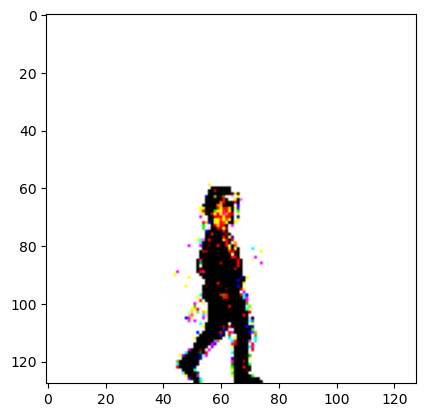

In [40]:
# Predict the next 9 frames using the trained U-Net model
input_image = prepare_input_image(image_path)  # Your function to load and prepare the input
predicted_frames = model.predict(input_image)

# Reapply the dominant colors to the predicted frames
final_frames = reapply_dominant_colors(predicted_frames, dominant_colors)

# Visualize or save the frames
for i, frame in enumerate(final_frames):
    plt.imshow((frame[1]))  # Convert back to [0, 255]
    plt.show()

In [34]:
len(final_frames[0][0][0])

3

In [23]:
# Post-process the predicted frames if necessary
final_frames = final_frames.squeeze()  # Remove the batch dimension if needed
print(f"Final frames shape: {final_frames.shape}")  # Should be (9, 128, 128, 3)

# Optionally, save the predicted frames or display them
for i in range(final_frames.shape[0]):
    frame = (final_frames[i] * 255).astype(np.uint8)  # Convert back to [0, 255]
    # Image.fromarray(frame).save(f"predicted_frame_{i}.png")

Final frames shape: (9, 128, 128, 3)


In [25]:
merged_frames = merge_frames(input_image, final_frames)
print("Merged shape:", merged_frames.shape)  # Expected Output: (10, 128, 128, 3)

Merged shape: (10, 128, 128, 3)


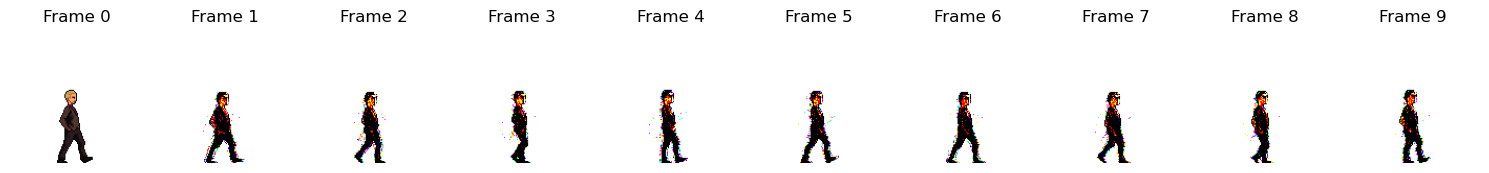

In [26]:
display_predicted_frames(merged_frames)

In [15]:
animate_frames(merged_frames)

In [16]:
img_path = "/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.png"
input_img = Image.open(image_path).convert('RGB').resize((128, 128))
input_img = np.array(input_img)
input_img.shape

(128, 128, 3)

In [17]:
# # saving gif file

# def animate_frames(predicted_frames, save_path=None, fps=5):
#     """
#     Create, display, and optionally save an animation from predicted frames in Jupyter Notebook.
    
#     Parameters:
#     predicted_frames (numpy array): Array of predicted frames, expected shape (num_frames, 128, 128, 3).
#     save_path (str, optional): Path to save the animation (supports formats like .mp4 or .gif).
#     fps (int, optional): Frames per second for the animation. Default is 5 fps.
#     """
#     num_frames = predicted_frames.shape[0]

#     # Create a figure
#     fig, ax = plt.subplots()

#     # Display the first frame initially
#     img = ax.imshow(predicted_frames[0], animated=True)
#     ax.axis('off')  # Hide the axis for visual appeal

#     # Update function for the animation
#     def update(frame_num):
#         img.set_array(predicted_frames[frame_num])  # Update the image data with the new frame
#         return [img]

#     # Create the animation: FuncAnimation creates a new image every interval
#     ani = FuncAnimation(
#         fig, update, frames=num_frames, interval=1000//fps, blit=True  # interval in ms
#     )

#     if save_path:
#         # Save the animation
#         if save_path.endswith(".mp4"):
#             ani.save(save_path, writer="ffmpeg", fps=fps)
#         elif save_path.endswith(".gif"):
#             ani.save(save_path, writer="pillow", fps=fps)
#         print(f"Animation saved to {save_path}")
    
#     # Display the animation in Jupyter
#     plt.close(fig)  # Close the figure to prevent a static image from being displayed
#     return HTML(ani.to_jshtml())

# animate_frames(merged_frames, '/Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.gif', fps=5)

Animation saved to /Users/lofichill/Desktop/NIPA/project/test_frames/frame_5_0.gif
